In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, concatenate
from keras.layers import GaussianDropout, GaussianNoise
from keras.layers import GRU, Bidirectional, TimeDistributed
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import os
import re
import numpy as np
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
# DATASET
DATASET_COLUMNS = ["target", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S"

# WORD2VEC
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 6
W2V_SIZE = 200

SEQUENCE_LENGTH = 200

MAXLEN = 100
MAX_SENTENCES = 15
MAX_WORDS = 20000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [30]:
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

# class defining the Bahdanau attention layer
class BahdanauAttentionNetwork(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(BahdanauAttentionNetwork, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim,)))
        self.trainable_weights = [self.W, self.b]
        super(BahdanauAttentionNetwork, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        eij = K.tanh(K.bias_add(K.dot(x, self.W), self.b))

        a = K.exp(eij)

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting
            a *= K.cast(mask, K.floatx())
                     
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        #print(a.shape)
        #print(x.shape)
        #print(K.expand_dims(a).shape)
        weighted_input = x * a
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [4]:
df_train = pd.read_csv("yelp2015/train.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
df_test = pd.read_csv("yelp2015/test.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [5]:
def preprocess(text):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
      tokens.append(token)
    return " ".join(tokens)

In [6]:
%%time
df_train.text = df_train.text.apply(lambda x: preprocess(x))
df_test.text = df_test.text.apply(lambda x: preprocess(x))

Wall time: 20.8 s


In [7]:
decode_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df_train.target = df_train.target.apply(lambda x: decode_sentiment(x))
df_test.target = df_test.target.apply(lambda x: decode_sentiment(x))

Wall time: 412 ms


In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\covin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
from gensim.models import Word2Vec

w2v_model = Word2Vec.load("w2v2_modregex_200.w2v")

2020-05-06 10:43:22,269 : INFO : loading Word2Vec object from w2v2_modregex_200.w2v
2020-05-06 10:43:22,882 : INFO : loading wv recursively from w2v2_modregex_200.w2v.wv.* with mmap=None
2020-05-06 10:43:22,882 : INFO : loading vectors from w2v2_modregex_200.w2v.wv.vectors.npy with mmap=None
2020-05-06 10:43:22,952 : INFO : setting ignored attribute vectors_norm to None
2020-05-06 10:43:22,953 : INFO : loading vocabulary recursively from w2v2_modregex_200.w2v.vocabulary.* with mmap=None
2020-05-06 10:43:22,954 : INFO : loading trainables recursively from w2v2_modregex_200.w2v.trainables.* with mmap=None
2020-05-06 10:43:22,954 : INFO : loading syn1neg from w2v2_modregex_200.w2v.trainables.syn1neg.npy with mmap=None
2020-05-06 10:43:23,028 : INFO : setting ignored attribute cum_table to None
2020-05-06 10:43:23,029 : INFO : loaded w2v2_modregex_200.w2v


In [11]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 152070


In [12]:
from nltk import tokenize

reviews = []
labels = []
texts = []

for idx, _ in df_train.iterrows():
    text = df_train.text[idx]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)
    labels.append(df_train.target[idx])

TRAIN_SIZE = len(texts)

for idx, _ in df_test.iterrows():
    text = df_test.text[idx]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)
    labels.append(df_test.target[idx])

In [13]:
from keras.preprocessing.text import text_to_word_sequence

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTENCES, MAXLEN), dtype='int32')

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTENCES:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
                if k < MAXLEN and tokenizer.word_index[word] < MAX_WORDS:
                    data[i, j, k] = tokenizer.word_index[word]
                    k = k + 1

word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 274081 unique tokens.


In [14]:
from keras.utils.np_utils import to_categorical

labels = to_categorical(np.asarray(labels))
print('Shape of reviews (data) tensor:', data.shape)
print('Shape of sentiment (label) tensor:', labels.shape)

Shape of reviews (data) tensor: (700000, 15, 100)
Shape of sentiment (label) tensor: (700000, 5)


In [15]:
x_train = data[:TRAIN_SIZE]
y_train = labels[:TRAIN_SIZE]
x_test = data[TRAIN_SIZE:]
y_test = labels[TRAIN_SIZE:]

In [16]:
# building Hierachical Attention network
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]

embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
                            input_length=MAXLEN, trainable=False)

In [31]:
sentence_input = Input(shape=(MAXLEN,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
lstm_word = Bidirectional(GRU(50, return_sequences=True))(embedded_sequences)
attn_word = BahdanauAttentionNetwork(100)(lstm_word)
sentenceEncoder = Model(sentence_input, attn_word)

review_input = Input(shape=(MAX_SENTENCES, MAXLEN), dtype='int32')
review_encoder = TimeDistributed(sentenceEncoder)(review_input)
lstm_sentence = Bidirectional(GRU(50, return_sequences=True))(review_encoder)
attn_sentence = BahdanauAttentionNetwork(100)(lstm_sentence)
preds = Dense(5, activation='softmax')(attn_sentence)
model = Model(review_input, preds)

tracking <tf.Variable 'bahdanau_attention_network_13/Variable:0' shape=(100, 100) dtype=float32> W
tracking <tf.Variable 'bahdanau_attention_network_13/Variable_1:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'bahdanau_attention_network_14/Variable:0' shape=(100, 100) dtype=float32> W
tracking <tf.Variable 'bahdanau_attention_network_14/Variable_1:0' shape=(100,) dtype=float32> b


In [32]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 15, 100)           0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 100)           54901800  
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 15, 100)           45300     
_________________________________________________________________
bahdanau_attention_network_1 (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 54,957,705
Trainable params: 141,305
Non-trainable params: 54,816,400
_________________________________________________________________


In [33]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5, mode='max')]

In [34]:
print("model fitting - Hierachical attention network")
history = model.fit(x_train, y_train, validation_split=0.2, nb_epoch=10, batch_size=64, callbacks=callbacks)

model fitting - Hierachical attention network


C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


2020-05-06 11:15:58,751 : WARNING : From C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 520000 samples, validate on 130000 samples
Epoch 1/10
520000/520000 [==============================] - 3235s 6ms/step - loss: 1.0720 - acc: 0.5177 - val_loss: 0.8808 - val_acc: 0.6154
Epoch 2/10
520000/520000 [==============================] - 3288s 6ms/step - loss: 0.9043 - acc: 0.6001 - val_loss: 0.8316 - val_acc: 0.6360
Epoch 3/10
520000/520000 [==============================] - 3350s 6ms/step - loss: 0.8696 - acc: 0.6154 - val_loss: 0.8106 - val_acc: 0.6465
Epoch 4/10
520000/520000 [==============================] - 3347s 6ms/step - loss: 0.8495 - acc: 0.6252 - val_loss: 0.7904 - val_acc: 0.6574
Epoch 5/10
520000/520000 [==============================] - 3348s 6ms/step - loss: 0.8348 - acc: 0.6321 - val_loss: 0.7808 - val_acc: 0.6603
Epoch 6/10
520000/520000 [==============================] - 3351s 6ms/step - loss: 0.8228 - acc: 0.6373 - val_loss: 0.7796 - val_acc: 0.6592
Epoch 7/10
520000/520000 [==============================] - 3351s 6ms/step - loss: 0.8133 - acc: 0.642

In [35]:
%%time
score = model.evaluate(x_test, y_test, batch_size=100)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

50000/50000 [==============================] - 114s 2ms/step

ACCURACY: 0.626479983329773
LOSS: 0.8505946266651153
Wall time: 1min 53s


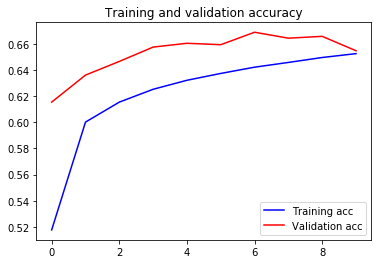

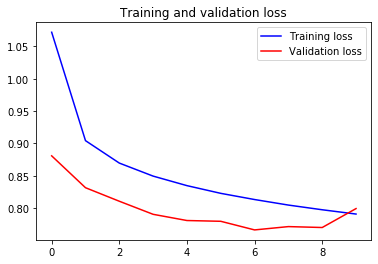

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [37]:
model.save("hatn_yelp_modregex_200d_bahdanau.h5")
#w2v_model.save("w2v2_modregex_200.w2v")
pickle.dump(tokenizer, open("tokenizer2_modregex_bahdanau.pkl", "wb"), protocol=0)

In [38]:
from nltk import tokenize
from keras.preprocessing.text import text_to_word_sequence

def predict_new_text(text, model, tokenizer):
    text = preprocess(text)
    texts = []
    reviews = []
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)

    data = np.zeros((len(texts), MAX_SENTENCES, MAXLEN), dtype='int32')

    for i, sentences in enumerate(reviews):
        for j, sent in enumerate(sentences):
            if j < MAX_SENTENCES:
                wordTokens = text_to_word_sequence(sent)
                k = 0
                for _, word in enumerate(wordTokens):
                    if k < MAXLEN and tokenizer.word_index[word] < MAX_WORDS:
                        data[i, j, k] = tokenizer.word_index[word]
                        k = k + 1
                        
    ynew = model.predict(data)
    return ynew

In [39]:
text = "the restaurant we went yesterday was wonderful."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[0.01238096 0.00668822 0.04637856 0.14053632 0.7940159 ]]
5


In [40]:
text = "the restaurant we went yesterday was awful. The food was bad, the service was bad. Horrible place, disgusting food."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[9.88760114e-01 1.09971445e-02 2.37422020e-04 3.12235989e-06
  2.22142990e-06]]
1


In [41]:
text = "The movie was good, funny and entertaining. Good cast and plot."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[0.00438263 0.04453542 0.5460467  0.3064604  0.09857486]]
3


In [42]:
text = "The movie was bad, boring and too slow paced. Bad cast and plot."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[5.6951261e-01 3.3995640e-01 8.8047132e-02 2.1548111e-03 3.2909802e-04]]
1


In [43]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


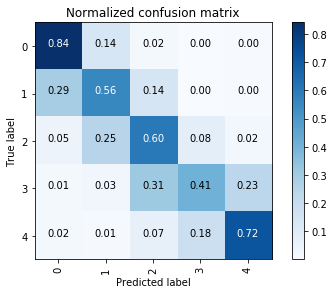

In [45]:
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
label_names = ['0', '1', '2', '3', '4']
plot_confusion_matrix(conf_matrix, classes=np.asarray(label_names), normalize=True,
                      title='Normalized confusion matrix')